Grover's Search Benchmark Program - Cirq
... execution starting at Jun 06, 2024 09:42:56 UTC
************
Executing [3] circuits with num_qubits = 2
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.0, 0.005, 0.002 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.022, 0.051, 0.004 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.966, 0.966

************
Executing [3] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.011, 0.005 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 0.962, 0.962

************
Executing [3] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.002, 0.016, 0.007 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 0.996, 0.996

************
Exec

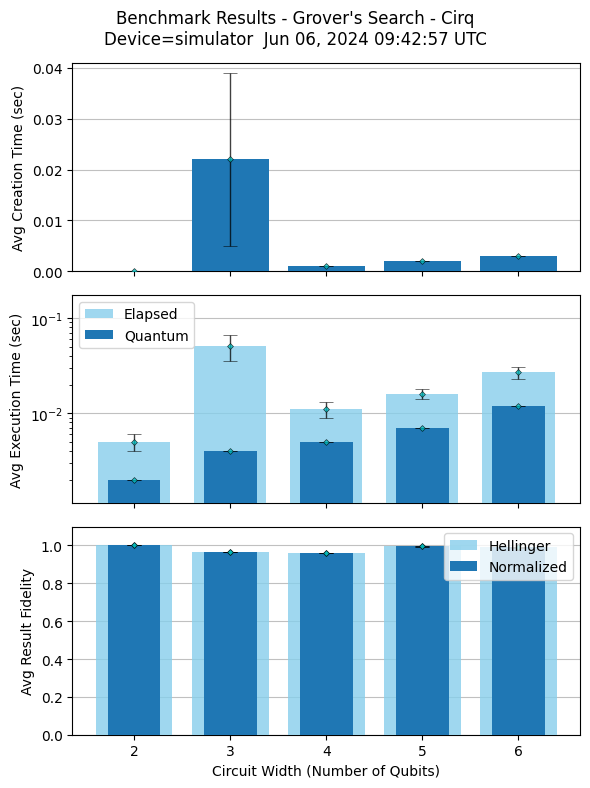

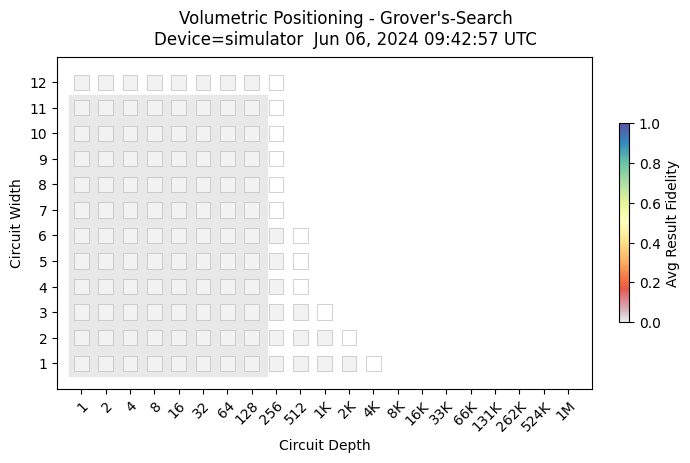

In [1]:
"""
Grover's Search Benchmark Program - Cirq
"""

from collections import defaultdict
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = ["_common", "_common/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
grover_oracle = None
diffusion_operator = None

############### Circuit Definition

def GroversSearch(num_qubits, marked_item, n_iterations):

    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # start with Hadamard on all qubits
    qc.append(cirq.H.on_each(*qr))

    # loop over the estimated number of iterations
    for _ in range(n_iterations):
    
        # add the oracle
        grover_oracle = create_grover_oracle(num_qubits, marked_item)
        qc.append(grover_oracle.on(*qr))
        
        # add the diffusion operator
        diffusion_operator =create_diffusion_operator(num_qubits)
        qc.append(diffusion_operator.on(*qr))

    # measure all qubits
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(num_qubits)], key='result'))

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

############## Grover Oracle

def create_grover_oracle(num_qubits, marked_item):
    global grover_oracle
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    marked_item_bits = format(marked_item, f"0{num_qubits}b")[::-1]
    qc.append([cirq.X(q) for (q, bit) in zip(qr, marked_item_bits) if not int(bit)])
    qc.append(cirq.Z(qr[-1]).controlled_by(*qr[0:-1]))
    qc.append([cirq.X(q) for (q, bit) in zip(qr, marked_item_bits) if not int(bit)])
    
    if grover_oracle == None or num_qubits <= 5:
        if num_qubits < 9: grover_oracle = qc
        
    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Oracle")

############## Grover Diffusion Operator

def create_diffusion_operator(num_qubits):
    global diffusion_operator
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    qc.append(cirq.H.on_each(*qr))
    qc.append(cirq.X.on_each(*qr))
    qc.append(cirq.Z(qr[-1]).controlled_by(*qr[0:-1]))
    qc.append(cirq.X.on_each(*qr))
    qc.append(cirq.H.on_each(*qr))

    if diffusion_operator == None or num_qubits <= 5:
        if num_qubits < 9: diffusion_operator = qc
        
    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Diffusor")

    
    
############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_qubits, marked_item, num_shots):
    
    # get measurement array
    measurements = result.measurements['result']
    
    # create counts distribution
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
    if verbose: print(f"For type {marked_item} measured: {counts}")

    # we compare counts to analytical correct distribution
    correct_dist = grovers_dist(num_qubits, marked_item)
    if verbose: print(f"Marked item: {marked_item}, Correct dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity

def grovers_dist(num_qubits, marked_item):
    
    n_iterations = int(np.pi * np.sqrt(2 ** num_qubits) / 4)
    
    dist = {}

    for i in range(2**num_qubits):
        key = bin(i)[2:].zfill(num_qubits)
        theta = np.arcsin(1/np.sqrt(2 ** num_qubits))
        
        if i == int(marked_item):
            dist[key] = np.sin((2*n_iterations+1)*theta)**2
        else:
            dist[key] = (np.cos((2*n_iterations+1)*theta)/(np.sqrt(2 ** num_qubits - 1)))**2
    return dist


################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=2, max_qubits=6, max_circuits=3, num_shots=100,
        backend_id='simulator', provider_backend=None):

    print("Grover's Search Benchmark Program - Cirq")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int, num_shots):

        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module   with the result handler  
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
        
        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            n_iterations = int(np.pi * np.sqrt(2 ** num_qubits) / 4)

            qc = GroversSearch(num_qubits, s_int, n_iterations)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time() - ts)

            qc = cirq.Circuit(cirq.decompose(op) for op in qc.all_operations())

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(num_qubits)
    # metrics.report_metrics_for_group(num_qubits)

    # # print a sample circuit created (if not too large)
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # print("\nOracle ="); print(grover_oracle if grover_oracle!= None else "  ... too large!")
    # print("\nDiffuser ="); print(diffusion_operator if diffusion_operator!= None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Grover's Search - Cirq")


# if main, execute method
if __name__ == '__main__': run()
